In [1]:
import sys
import climin
import warnings
import os
sys.path.append('..')

import fully_natural_gradient as fng
import load_datasets as pre
from importlib import reload
reload(fng)
reload(pre)

import numpy as np
from likelihoods.poisson import Poisson
from likelihoods.bernoulli import Bernoulli
from likelihoods.gaussian import Gaussian
from likelihoods.categorical import Categorical
from likelihoods.hetgaussian import HetGaussian
from likelihoods.beta import Beta
from likelihoods.gamma import Gamma
from likelihoods.exponential import Exponential

from hetmogp.util import draw_mini_slices
from hetmogp.het_likelihood import HetLikelihood
from hetmogp.svmogp import SVMOGP
from hetmogp import util
reload(util)

import matplotlib.pyplot as plt
import time
import getopt

%matplotlib inline

warnings.filterwarnings("ignore")
os.environ['PATH'] = os.environ['PATH'] + ':/usr/texbin'

""""""""""""""""""""""""""""""
#We define some color for future plots
""""""""""""""""""""""""""""""
which_color = {
		"Adam" : '#f39c12',
		"SGD" : '#21618c',
		"FNG" : '#c0392b',
		"HYB" : '#1e8449'
	}

""""""""""""""""""""""""""""""
font = {'family': 'serif',
            'weight': 'bold',
            'size': 14}

plt.rc('font', **font)
linewidth = 2.7
""""""""""""""""""""""""""""""    

''

This sections allows us to set the different configurations for running the code. We can pick a toy example bellow by changing self.dataset from 'toy1' to 'toy5' 

In [2]:
""""""""""""""""""""""""""""""
#Setting different configurations
""""""""""""""""""""""""""""""
class inital_config:
    def __init__(self):
        
        self.minibatch = 50               #change this one for setting the mini-batch size
        self.dimension = 3                #change this one for setting the input dimensionality
        self.N_iter = 500                 #change this one for setting the number of iteration
        self.dataset = 'toy2'            #change this one for setting the toy datset  
        self.MC = 1                       #change this one for setting the number of MC sample 
        self.mom = 0.9                    #change this one for setting the momentum of the FNG algoritm   
        self.inducing = 40                #change this one for setting the number of inducing points
        self.which_seed = 105             #set a seed for initialising the HetMOGP's hyper-parameters   

""""""""""""""""""""""""""""""
config = inital_config()
num_inducing = int(config.inducing)  # number of inducing points
batch = int(config.minibatch)
input_dim = int(config.dimension)
MC = int(config.MC)
mom = float(config.mom)

In [3]:
#We create a list with the methods we want to run for comparing performance
#The list can have the methods: 
#Stochastic Gradient Descent: 'SGD', Adaptive momentum: 'Adam',
#Hybrid (NG+Adam):'HYB' or Fully Natural Gradient': FNG'

methods = ['SGD','Adam','HYB','FNG']  
myseed = int(config.which_seed)
NLPD_Adam = []
NLPD_FNG = []
NLPD_SGD = []
NLPD_HYB = []
ELBO_Adam = []
ELBO_FNG = []
ELBO_SGD = []
ELBO_HYB = []


Starting Method: SGD
input_dim: 3
Initial ELBO's value for the model:  [[ -4.61877076e+12]]
Iteration: 50
[[-14244877.288283]]
Iteration: 100
[[-14231076.55124671]]
Iteration: 150
[[-14362504.80530231]]
Iteration: 200
[[-14244844.7062453]]
Iteration: 250
[[-14231043.82701594]]
Iteration: 300
[[-14362471.02368706]]
Iteration: 350
[[-14244812.12466352]]
Iteration: 400
[[-14231011.103263]]
Iteration: 450
[[-14362437.24255214]]
Iteration: 500
[[-14244779.54354337]]

NLPD per output using SGD method: [array([ 1.92076893, -0.03464858,  0.69338113,  1.55495444,  1.44212088])]

Starting Method: Adam
input_dim: 3
Initial ELBO's value for the model:  [[ -4.61877076e+12]]
Iteration: 50
[[-17587131.78180956]]
Iteration: 100
[[-19887094.81474499]]
Iteration: 150
[[-39032474.73933922]]
Iteration: 200
[[-13131865.97799258]]
Iteration: 250
[[-18124984.40502531]]
Iteration: 300
[[-27268925.58692395]]
Iteration: 350
[[-12201467.61106269]]
Iteration: 400
[[-16833940.08777487]]
Iteration: 450
[[-20286534

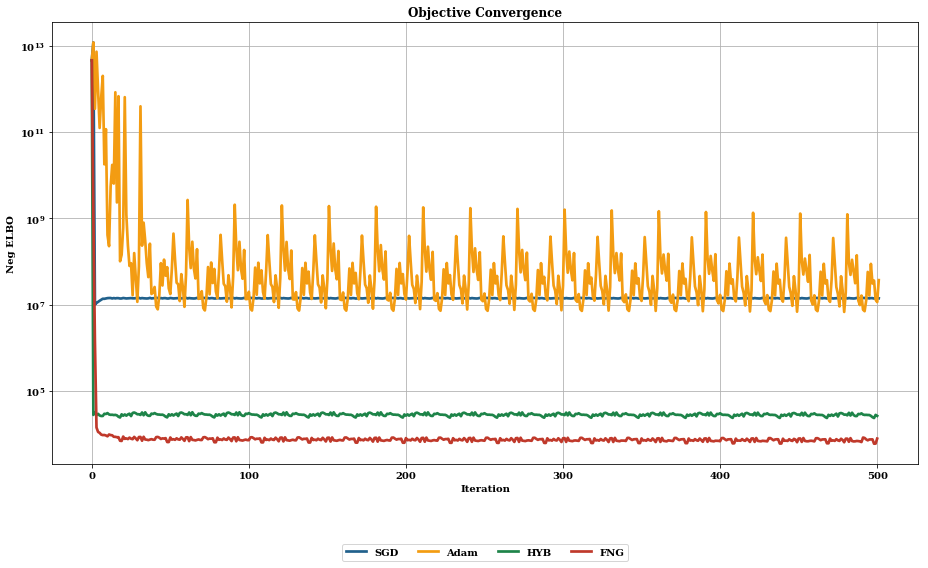

In [4]:
plt.close('all')
plt.figure(figsize=(13, 8))
#We run a for over the list of the different methods
for posmeth,method in enumerate(methods):
    print("\nStarting Method:", method)
    """"""""""""""""""""""""""""""""""""""
    #We set the random.seed(101) to guarantee
    #the same mini-batching or all the methods
    """"""""""""""""""""""""""""""""""""""
    np.random.seed(101)
    import random
    random.seed(101)
    model=[]

    """"""""""""""""""""""""""""""""""""""
    #The callback bellow is used for the methods SGD and Adam 
    """"""""""""""""""""""""""""""""""""""
    def callback(i):
        global n_iter, start, Xval, Yval
        global ELBO, myTimes, NLPD

        ELBO.append(model.log_likelihood())
        # if i['n_iter'] == 1:
        #     start = time.time()
        myTimes.append(time.time())

        if (i['n_iter']) % 50 == 0:
            print("Iteration:",i['n_iter'])
            print(model.log_likelihood())
        if i['n_iter'] > n_iter:
            myTimes = np.array(myTimes) - start
            return True
        return False
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    #We load below the toy datasets using the function load_Hetdata from module load_datasets
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    dataset=config.dataset
    Xtrain,Ytrain = pre.load_Hetdata(dataset=dataset,Ntoy=2000,Only_input_dim_toy=input_dim)
    """"""""""""""""""""""""""""""""""""""
    
    #Each of the toy examples below have the variables:
    #my_proportion is a list as long as the number of outputs, and it indicate the training proportion per output
    #my_proportion = [0.75, 0.75] means using 75% of data for training and 25% for validating for both outputs                          
    
    if dataset == 'toy1':
        Q = 3
        my_proportion = [0.75, 0.75, 0.75]  
        likelihoods_list = [HetGaussian(), Beta(), Bernoulli()]
    elif dataset == 'toy2':
        Q = 3
        my_proportion = [0.75, 0.75, 0.75, 0.75, 0.75]  
        likelihoods_list = [HetGaussian(), Beta(), Bernoulli(), Gamma(), Exponential()]
    elif dataset == 'toy3':
        Q = 3
        my_proportion = [0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75] 
        likelihoods_list = [HetGaussian(), Beta(), Bernoulli(), Gamma(), Exponential(), Gaussian(sigma=0.1), Beta(), Bernoulli(), Gamma(), Exponential()]
    elif dataset == 'toy4':
        Q = 3
        my_proportion = [0.75, 0.75]  
        likelihoods_list = [HetGaussian(), Beta()]
    elif dataset == 'toy5':
        Q = 3
        my_proportion = [0.75, 0.75, 0.75]  
        likelihoods_list = [HetGaussian(), Beta(), Gamma()]
    
    likelihood = HetLikelihood(likelihoods_list)
    Y_metadata = likelihood.generate_metadata()

    np.random.seed(101)
    myindex = []
    ind_split_aux = []

    if Ytrain.__len__() == 1:
        Kfold = 4
    else:
        Kfold = 2

    proportion = 1.0 / Kfold
    
    for d in range(Ytrain.__len__()):
        Ntotal, Dim = Xtrain[d].shape

        if Kfold==2:
            proportion = 1.0-my_proportion[d]

        myindex.append(np.random.permutation(np.arange(0, Ntotal)))
        ind_split_aux.append(np.split(myindex[d], np.arange(int(Ntotal * proportion), Ntotal, int(Ntotal * proportion))))
        if not (Ntotal % Kfold == 0):
            ind_split_aux[d] = ind_split_aux[d][0:Kfold]

    ind_split = [0.0] * Kfold
    for k in range(Kfold):
        ind_split[k] = []
        for d in range(Ytrain.__len__()):
            ind_split[k].append(ind_split_aux[d][k])

    # kmeans for selecting Z
    from scipy.cluster.vq import kmeans
    np.random.seed(myseed)
    #Z = 1.0 * kmeans(Xtrain, num_inducing)[0]

    minis = Xtrain[0].min(0)
    maxis = Xtrain[0].max(0)
    Dim = Xtrain[0].shape[1]
    Z = np.linspace(minis[0],maxis[0],num_inducing).reshape(1,-1)
    for i in range(Dim-1):
        Zaux = np.linspace(minis[i+1],maxis[i+1],num_inducing)
        Z = np.concatenate((Z,Zaux[np.random.permutation(num_inducing)].reshape(1,-1)),axis=0)
        #Z = np.concatenate((Z, Zaux.reshape(1, -1)), axis=0)
    Z = 1.0*Z.T

    n_iter = int(config.N_iter)
    all_NLPD = []
    Times_all = []
    ELBO_all =[]
    for fold, index in enumerate(ind_split):
        ELBO = []
        NLPD = []
        myTimes = []
        if fold==1:
            #    break
            #ind = np.delete(myindex, index)
            Y = [Yaux[np.delete(myindex[d], index[d])].copy() for d,Yaux in enumerate(Ytrain)]
            X = [Xaux[np.delete(myindex[d], index[d]), :].copy() for d,Xaux in enumerate(Xtrain)]
            Yval = [Yaux[index[d]].copy() for d,Yaux in enumerate(Ytrain)]
            Xval = [Xaux[index[d], :].copy() for d,Xaux in enumerate(Xtrain)]

            #np.random.seed(int(config.seed))
            """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
            #Random lengthscale initialisation of for Exponentiated Quadratic   
            """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
            np.random.seed(myseed)
           
            ls_q = np.sqrt(Dim) * (np.random.rand(Q) + 0.001)
            var_q = 1.0 * np.ones(Q)  
            kern_list = util.latent_functions_prior(Q, lenghtscale=ls_q, variance=var_q, input_dim=Dim)
            """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
            
            """""""""""""""""""""""""""""""""Creating the HeMOGP Model"""""""""""""""""""""""""""""""""
            random.seed(101)   #We use this seed to guarantee all inner variables of the model be fairly started for methods
            model = SVMOGP(X=X, Y=Y, Z=Z.copy(), kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata,batch_size=batch)
            #model.Z.fix()
            model['.*.kappa'].fix()
            
            """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
            #Random initialisation of the linear combination coefficients 
            """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
            for q in range(Q):
                model['B_q' + str(q) + '.W'] = 2.0 * np.random.rand(model['B_q0.W'].__len__())[:, None]
                model.kern_list[q].rbf.variance.fix()
                model.kern_list[q].white.variance = 1.0e-8
                model.kern_list[q].white.fix()
            """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""" 
            
            print("Initial ELBO's value for the model: ",model.log_likelihood())

            """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
            #Below we set the methods' configuration
            """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
            if method == 'Adam':
                opt = climin.Adam(model.optimizer_array, model.stochastic_grad, step_rate=0.01, decay_mom1=1 - 0.9,decay_mom2=1 - 0.999)
                ELBO.append(model.log_likelihood())
                start = time.time()
                myTimes.append(start)
                info = opt.minimize_until(callback)

            elif method == 'SGD':
                opt = climin.GradientDescent(model.optimizer_array, model.stochastic_grad, step_rate=1e-15, momentum=0.5)
                ELBO.append(model.log_likelihood())
                start = time.time()
                myTimes.append(start)
                info = opt.minimize_until(callback)
            elif method == 'FNG':
                model.Gauss_Newton = False
                ELBO, NLPD, myTimes = fng.fullyng_opt_HetMOGP(model, max_iters=n_iter, step_size=0.01, momentum=mom,MC=MC)
            elif method=='HYB':
                model.Gauss_Newton = False
                ELBO, NLPD, myTimes = fng.hybrid_opt_HetMOGP(model, max_iters=n_iter, step_rate=0.01, decay_mom1=1-0.9,decay_mom2=1-0.999)

            Times_all.append(np.array(myTimes).flatten())
            ELBO_all.append(np.array(ELBO).flatten())

            np.random.seed(101)
            eval('NLPD_' + method + '.append(model.negative_log_predictive(Xval,Yval))')
            print("\nNLPD per output using "+method.upper()+" method:", eval('NLPD_' + method ))

        
    """"""""""""""""""""""""""""""""""""
    #Plot of the convergence
    """"""""""""""""""""""""""""""""""""
    color = which_color[method]
    plt.semilogy(-ELBO_all[0], color, linewidth=linewidth, label=method)
    plt.title("Objective Convergence",fontweight="bold")
    plt.xlabel("Iteration", fontweight="bold")
    plt.ylabel("Neg ELBO", fontweight="bold")
    if (ELBO_all[0].max() > 0):
        plt.yscale('symlog')
    else:
        plt.yscale('log')
    plt.grid(True, which='both')
    plt.gca().legend(methods, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.17))
    plt.tight_layout()
    #plt.savefig(dataset+'.png')